# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set()
import datetime
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
import scipy as stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_2019 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2017.csv', sep =',')

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [10]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [11]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [12]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [13]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


# Parte A - Exploración de Datos

In [14]:
#EDA:

from pandas_profiling import ProfileReport
reporte = ProfileReport(dataset)
reporte.to_file("Reporte_EDA.html")
reporte.to_widgets()

In [15]:
print('Muestras del dataset:', dataset.shape[0])
print('Variables del dataset:', dataset.shape[1])

Muestras del dataset: 238869
Variables del dataset: 5


In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238869 entries, 0 to 238868
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   sentido         238869 non-null  object        
 2   tipo_vehiculo   238869 non-null  object        
 3   cantidad_pasos  238869 non-null  int64         
 4   fecha           238869 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.1+ MB


In [17]:
pd.DataFrame(dataset.columns, columns=['Variables'], index=np.arange(1,6))

,Variables
1,dia
2,sentido
3,tipo_vehiculo
4,cantidad_pasos
5,fecha


In [18]:
#Dataset sin valores faltantes:

dataset.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

#### El dataset no presenta valores faltantes.

### _Mediante la función "groupby", procedo a examinar la distribución de mis variables:

In [19]:
dataset.groupby('dia')['cantidad_pasos'].sum().sort_values(ascending=False)

dia
Viernes      7647272
Jueves       7302169
Miércoles    7125526
Martes       6865551
Lunes        6691387
Sábado       6441715
Domingo      5791961
Name: cantidad_pasos, dtype: int64

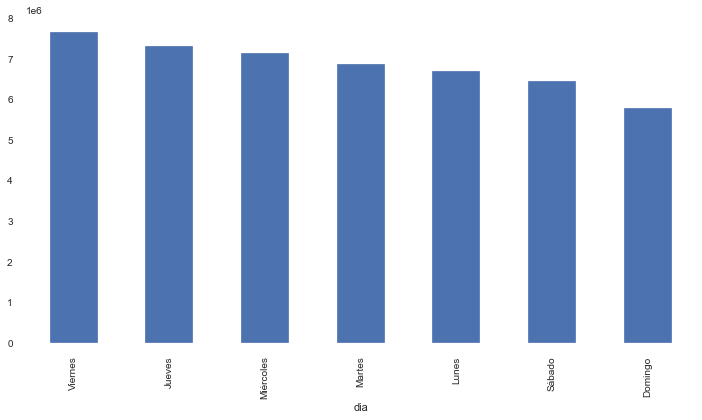

In [20]:
fig, ax = plt.subplots(figsize=(12,6))
dataset.groupby('dia')['cantidad_pasos'].sum().sort_values(ascending=False).plot(ax=ax,kind='bar')

#### _SE DETECTA UNA FRECUENCIA ESTABLE ENTRE LOS DÍAS MIÉRCOLES Y VIERNES (7.125.526-7.647.272). POR SU PARTE, LUNES Y MARTES MUESTRAN UN LEVE DESCENSO EN LA CANTIDAD DE PASOS CON RESPECTO AL CIERRE DE LA SEMANA LABORAL. POR ÚLTIMO, AMBOS DÍAS DEL FIN DE SEMANA EXHIBEN LA MENOR CIRCULACIÓN EN EL PEAJE EN CUESTIÓN. EXISTE UNA DIFERENCIA DE CASI 2.000.000 DE VEHÍCULOS ENTRE EL DÍA DE MAYOR TRÁNSITO (VIERNES) Y EL DE MENOR (DOMINGO). 

In [21]:
dataset.groupby('sentido')['cantidad_pasos'].sum().sort_values(ascending=False)

sentido
Centro       24707366
Provincia    23158215
Name: cantidad_pasos, dtype: int64

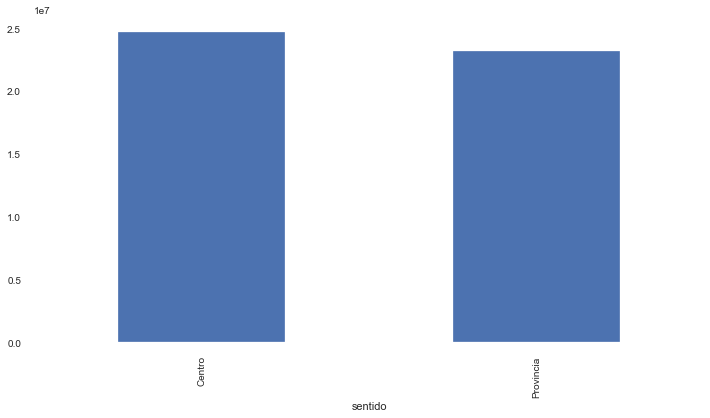

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
dataset.groupby('sentido')['cantidad_pasos'].sum().sort_values(ascending=False).plot(ax=ax,kind='bar')

In [23]:
dataset.groupby('tipo_vehiculo')['cantidad_pasos'].sum().sort_values(ascending=False)

tipo_vehiculo
Liviano    46338529
Pesado      1527052
Name: cantidad_pasos, dtype: int64

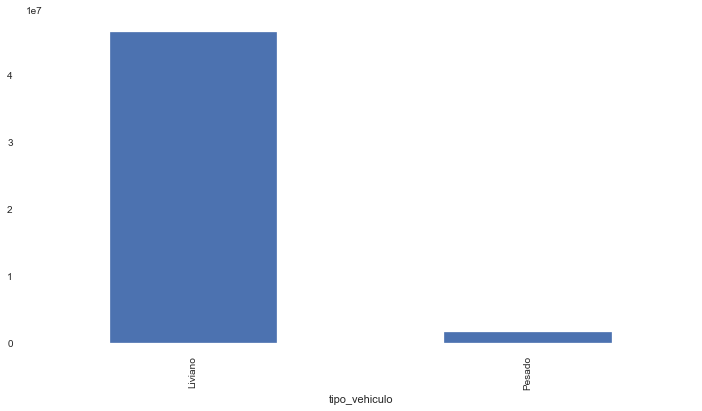

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
dataset.groupby('tipo_vehiculo')['cantidad_pasos'].sum().sort_values(ascending=False).plot(ax=ax,kind='bar')

#### _LA DISTRIBUCIÓN ENTRE VEHÍCULOS CON SENTIDO HACIA CENTRO Y PROVINCIA MUESTRAN VALORES SIMILARES. A SU VEZ, ACERCA DEL TIPO DE VEHÍCULO EN CONSIDERACIÓN, LA DIFERENCIA ENTRE LIVIANOS Y PESADOS ES SUSTANCIAL (ALREDEDOR DE 30 A 1).

In [25]:
#FECHA INDEXADA: 

In [26]:
dataset_2 = dataset.set_index('fecha')

In [27]:
dataset_2.head(5).append(dataset_2.tail(5))

,dia,sentido,tipo_vehiculo,cantidad_pasos
fecha,,,,
2017-01-01 00:00:00,Domingo,Provincia,Pesado,1
2017-01-01 00:00:00,Domingo,Provincia,Liviano,9
2017-01-01 00:00:00,Domingo,Provincia,Liviano,644
2017-01-01 00:00:00,Domingo,Provincia,Pesado,6
2017-01-01 00:00:00,Domingo,Provincia,Pesado,1
2019-12-31 22:00:00,Martes,Provincia,Liviano,556
2019-12-31 22:00:00,Martes,Provincia,Pesado,1
2019-12-31 22:00:00,Martes,Centro,Liviano,580
2019-12-31 23:00:00,Martes,Centro,Liviano,214


### Para profundizar el análisis exploratorio de datos, desagrego los valores de la variables 'fecha' en 'año', 'mes', 'semana', 'día' y 'hora':

In [28]:
dataset_2['Year'] = dataset_2.index.year
dataset_2['Month'] = dataset_2.index.month
dataset_2['WeekOfYear'] = dataset_2.index.weekofyear
dataset_2['Day'] = dataset_2.index.day
dataset_2['Hour'] = dataset_2.index.hour

In [29]:
dataset_2.sample(10)

,dia,sentido,tipo_vehiculo,cantidad_pasos,Year,Month,WeekOfYear,Day,Hour
fecha,,,,,,,,,
2018-08-16 17:00:00,Jueves,Centro,Pesado,1,2018,8,33,16,17
2017-04-12 09:00:00,Miércoles,Provincia,Liviano,1223,2017,4,15,12,9
2019-04-05 11:00:00,Viernes,Provincia,Pesado,28,2019,4,14,5,11
2017-05-12 12:00:00,Viernes,Centro,Pesado,15,2017,5,19,12,12
2017-02-10 20:00:00,Viernes,Centro,Pesado,5,2017,2,6,10,20
2017-05-12 18:00:00,Viernes,Centro,Pesado,2,2017,5,19,12,18
2017-04-24 01:00:00,Lunes,Provincia,Pesado,1,2017,4,17,24,1
2017-11-11 06:00:00,Sábado,Centro,Pesado,1,2017,11,45,11,6
2018-04-30 19:00:00,Lunes,Provincia,Pesado,3,2018,4,18,30,19


In [30]:
dataset_2.groupby('Hour')['cantidad_pasos'].sum().sort_values(ascending=False)

Hour
18    3115036
19    3071455
14    3005578
17    2993721
16    2969568
15    2933388
13    2907990
12    2729369
20    2661885
11    2551110
9     2476701
10    2471790
21    2339949
8     2276977
22    1875810
7     1564013
23    1412685
0     1057141
1      879116
6      781617
2      614594
3      429898
5      411330
4      334860
Name: cantidad_pasos, dtype: int64

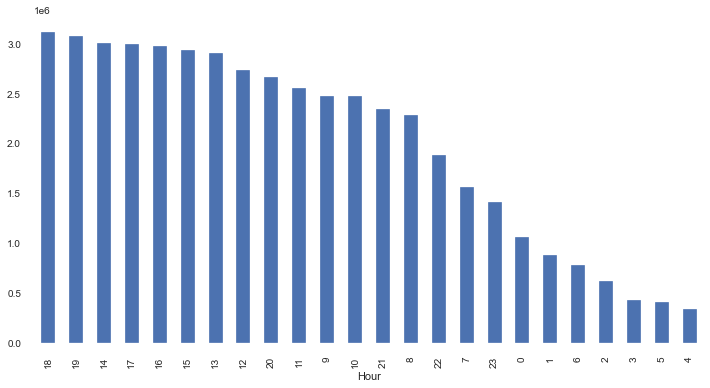

In [31]:
fig, ax = plt.subplots(figsize=(12,6))
dataset_2.groupby('Hour')['cantidad_pasos'].sum().sort_values(ascending=False).plot(ax=ax,kind='bar')

In [32]:
pasos = dataset_2.groupby('Hour')['cantidad_pasos'].sum()
pasos_2017 = dataset_2[(dataset_2.Year == 2017)].groupby('Hour')['cantidad_pasos'].sum()
pasos_2018 = dataset_2[(dataset_2.Year == 2018)].groupby('Hour')['cantidad_pasos'].sum()
pasos_2019 = dataset_2[(dataset_2.Year == 2019)].groupby('Hour')['cantidad_pasos'].sum()
x = dataset_2.Hour.unique()

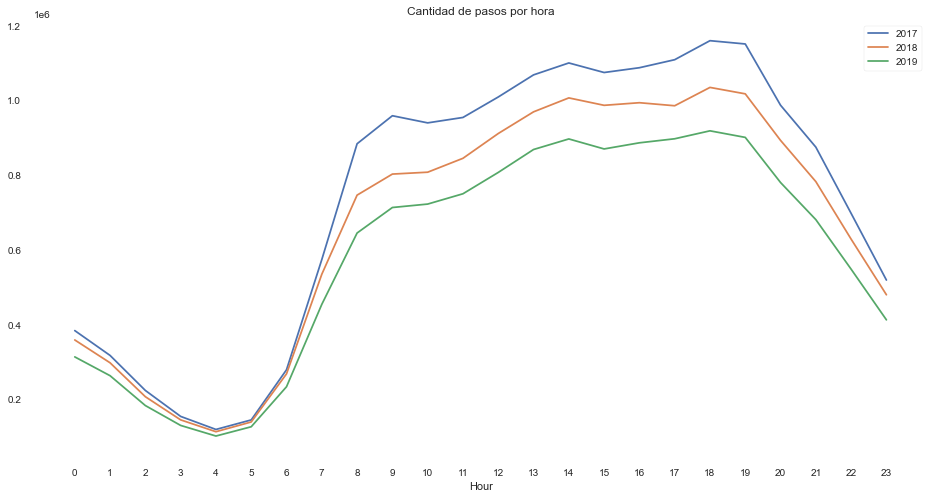

In [33]:
plt.figure(figsize=(16,8))
plt.title('Cantidad de pasos por hora')
pasos_2017.plot(xticks=x, label='2017')
pasos_2018.plot(xticks=x, label='2018')
pasos_2019.plot(xticks=x, label='2019')
plt.legend()
plt.show()

#### _OBSERVANDO LA DISTRIBUCIÓN POR HORA, EL HORARIO DIARIO DE MAYOR CARGA SE DA ENTRE LAS 13.00 Y LAS 19.00. EN UN SEGUNDO NIVEL DE FRECUENCIA, APARECEN LOS RANGOS 08.00-11.00 Y 20.00-21.00. EL MENOR TRÁNSITO SE DA ENTRE LAS 00.00 Y LAS 6.00 DE CADA DÍA. PARA AGREGAR, A CONTINUACIÓN SE COMPARARÁ LA CANTIDAD DE PASOS POR HORA EN AMBOS SENTIDOS DISPONIBLES.

In [34]:
dataset_2[['sentido','Hour','cantidad_pasos']].groupby(['sentido','Hour']).agg({'cantidad_pasos': 'sum'})

cantidad_pasos
sentido   Hour                
Centro    0             522898
          1             413334
          2             292850
          3             207214
          4             157183
          5             197089
          6             400152
          7             889332
          8            1282845
          9            1381388
          10           1405610
          11           1411597
          12           1466651
          13           1475201
          14           1478471
          15           1395862
          16           1373608
          17           1417309
          18           1589601
          19           1636851
          20           1433829
          21           1226824
          22            961951
          23            689716
Provincia 0             534243
          1             465782
          2             321744
          3             222684
          4             177677
          5             214241
          6             381465
          7             674681
          8             994132
          9            1095313
          10           1066180
          11           1139513
          12           1262718
          13           1432789
          14           1527107
          15           1537526
          16           1595960
          17           1576412
          18           1525435
          19           1434604
          20           1228056
          21           1113125
          22            913859
          23            722969

### DISTRIBUCIÓN DE TRÁNSITO POR AÑO Y POR MES:

In [35]:
dataset_2.groupby('Year')['cantidad_pasos'].sum().sort_values(ascending=False)

Year
2017    17783512
2018    15966944
2019    14115125
Name: cantidad_pasos, dtype: int64

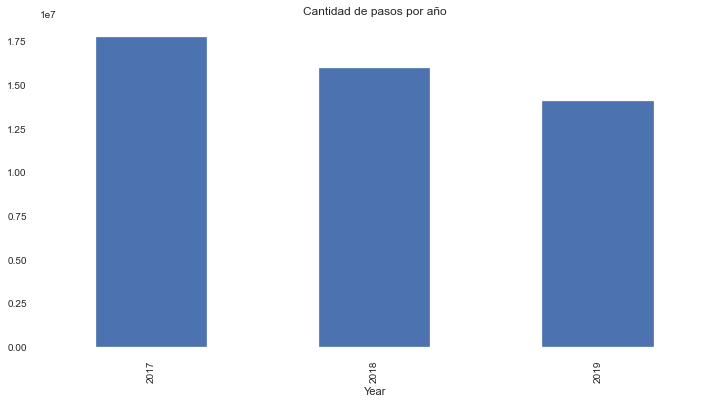

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
dataset_2.groupby('Year')['cantidad_pasos'].sum().plot(ax=ax,kind='bar', title='Cantidad de pasos por año')

#### _El gráfico muestra la tendencia decreciente en la cantidad de pasos por los pejas de Autopista Illia (sentidos centro y provincia) abonados en efectivo entre los años 2017 y 2019. La explicación radica en la tendencia creciente en los pagos vía Telepase. Entonces, ¿qué ocurre con la cantidad de pasos cuando aplicamos el filtro para forma de pago con Telepase? A continuación, la explicación del comportamiento del tráfico en la autopista Illia únicamente con uso de este nuevo dispositivo tecnológico.

### Repito los primeros pasos para conformar el dataset, pero filtrando por forma de pago 'Telepase':

In [37]:
dataset_telepase = pd.concat([data_2019, data_2018, data_2017])

mask = np.logical_and(dataset_telepase.estacion=='Illia', dataset_telepase.forma_pago == 'TELEPASE')

dataset_telepase = dataset_telepase[mask]

dataset_telepase.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset_telepase['fecha2'] = pd.to_datetime(dataset_telepase.fecha) + pd.to_timedelta(dataset_telepase.hora_fin, unit = 'h')

dataset_telepase.drop(columns=['fecha','hora_fin'], inplace = True)

dataset_telepase.rename(columns = {'fecha2':'fecha'}, inplace = True) 

dataset_telepase.sort_values('fecha', inplace = True)

dataset_telepase.reset_index(drop=True, inplace = True)

dataset_telepase = dataset_telepase.set_index('fecha')

dataset_telepase['Year'] = dataset_telepase.index.year

dataset_telepase.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,Year
fecha,,,,,
2017-01-01,Domingo,Centro,Pesado,9,2017
2017-01-01,Domingo,Provincia,Pesado,3,2017
2017-01-01,Domingo,Provincia,Pesado,7,2017
2017-01-01,Domingo,Provincia,Liviano,275,2017
2017-01-01,Domingo,Centro,Liviano,459,2017


In [38]:
dataset_telepase.groupby('Year')['cantidad_pasos'].sum().sort_values(ascending=False)

Year
2019    18692375
2018    17096004
2017    14737699
Name: cantidad_pasos, dtype: int64

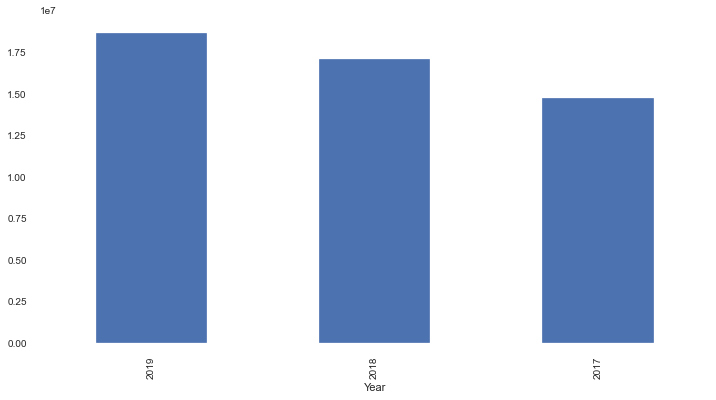

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
dataset_telepase.groupby('Year')['cantidad_pasos'].sum().sort_values(ascending=False).plot(ax=ax,kind='bar')

## El gráfico por año con pago con Telepase es inversamente proporcional al gráfico con pago en efectivo.

In [40]:
dataset_2.groupby('Month')['cantidad_pasos'].sum().sort_values(ascending=False)

Month
3     4251579
1     4129950
7     4096365
10    4062584
8     4050919
11    3987393
5     3970958
12    3927665
4     3907378
9     3906155
2     3805285
6     3769350
Name: cantidad_pasos, dtype: int64

# RESAMPLEOS:

## Frecuencia muestral mensual

In [41]:
#Resampleamos nuestros datos para agrupar por mes, y asi tal vez lograr una visualización mas amigable
mensual = dataset.resample('M', on = 'fecha').sum()
print(mensual.shape)
mensual.head()

(36, 1)


,cantidad_pasos
fecha,
2017-01-31,1565260
2017-02-28,1363113
2017-03-31,1451214
2017-04-30,1373985
2017-05-31,1407136


In [42]:
mensual.cantidad_pasos.describe()

count    3.600000e+01
mean     1.329599e+06
std      1.478281e+05
min      1.103086e+06
25%      1.193708e+06
50%      1.336892e+06
75%      1.429054e+06
max      1.597356e+06
Name: cantidad_pasos, dtype: float64

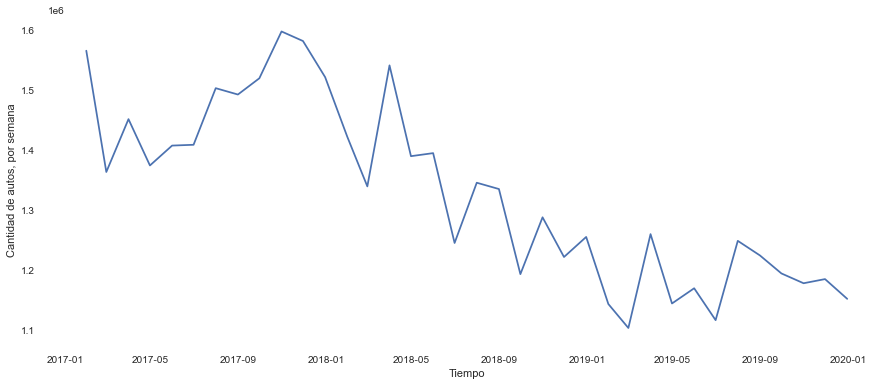

In [43]:
plt.figure(figsize = (15,6))
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

## Frecuencia muestral semanal

In [44]:
#Resampleamos nuestros datos para agrupar por semana, y asi tal vez lograr una visualización mas amigable
semanal = dataset.resample('W', on = 'fecha').sum()
print(semanal.shape)
semanal.head()

(158, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-08,347212
2017-01-15,366413
2017-01-22,357215
2017-01-29,354581


In [45]:
semanal.cantidad_pasos.describe()

count       158.000000
mean     302946.715190
std       47342.854449
min       31183.000000
25%      276345.250000
50%      307094.000000
75%      334921.500000
max      377832.000000
Name: cantidad_pasos, dtype: float64

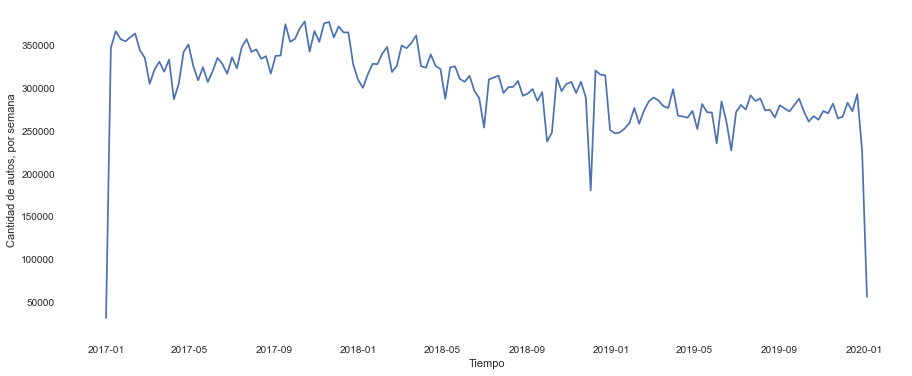

In [46]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.show()

In [311]:
#Autocorrelación en dataset con frecuencia muestral semanal:

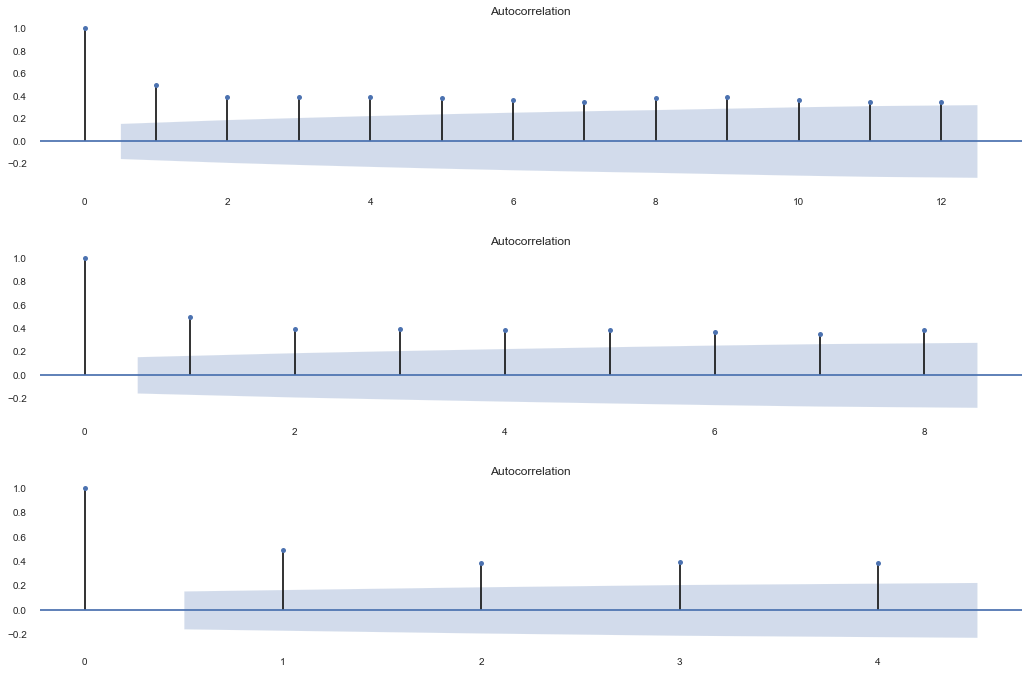

In [312]:
plt.figure(figsize=(15,10))
plt.subplot(311)
plot_acf(semanal.cantidad_pasos, lags=12, ax=plt.gca())
plt.subplot(312)
plot_acf(semanal.cantidad_pasos, lags=8, ax=plt.gca())
plt.subplot(313)
plot_acf(semanal.cantidad_pasos, lags=4, ax=plt.gca())
plt.tight_layout(pad=3.0)
plt.show()

## Frecuencia muestral diaria

In [50]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [51]:
diario.cantidad_pasos.describe()

count     1095.000000
mean     43712.859361
std       8192.736927
min          0.000000
25%      39061.500000
50%      43761.000000
75%      49498.000000
max      63127.000000
Name: cantidad_pasos, dtype: float64

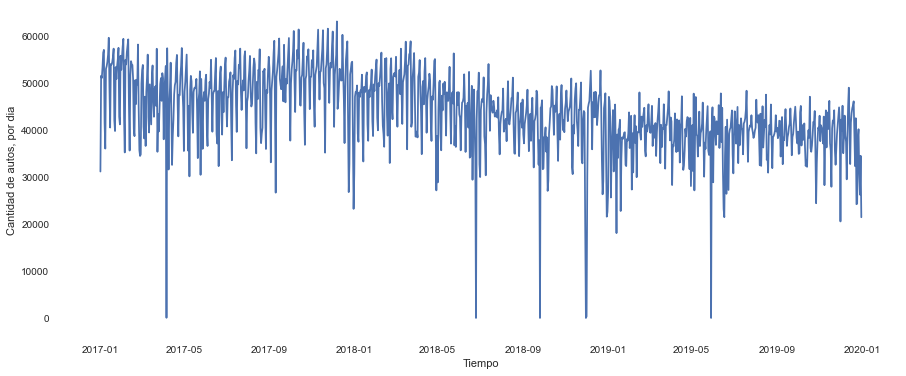

In [52]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

#### _Se detectan algunos valores atípicos inferiores al primer cuartil de la distribución.

In [53]:
nulos = diario[(diario.cantidad_pasos == 0)]
print(nulos)

            cantidad_pasos
fecha                     
2018-06-25               0
2018-09-25               0
2018-11-30               0
2019-05-29               0


In [54]:
primer_cuartil = np.quantile(diario['cantidad_pasos'], 0.25)
tercer_cuartil = np.quantile(diario['cantidad_pasos'], 0.75)
rango_intercuartílico = tercer_cuartil - primer_cuartil
mínimo_permitido = primer_cuartil - (1.5*rango_intercuartílico)
máximo_permitido = tercer_cuartil + (1.5*rango_intercuartílico)
outliers = diario[(diario.cantidad_pasos < mínimo_permitido) | (diario.cantidad_pasos > máximo_permitido)]

In [55]:
outliers

,cantidad_pasos
fecha,
2017-04-06,40
2017-12-31,23229
2018-06-25,0
2018-09-25,0
2018-11-29,19728
2018-11-30,0
2018-12-01,350
2018-12-30,21559
2018-12-31,22599


#### _ ¿Cómo se explican los valores atípicos? En primera medida, hay que aclarar que no se encontraron "outliers" por encima del máximo de la variable. Con relación a las instancias halladas por debajo del umbral seleccionado, los únicos cuatro días registrados en los que se detecta 0 paso de vehículos tiene que ver con paros nacionales (25/6 y 25/9 de 2018, y 29/5 de 2019) y el feriado decretado con motivo de la cumbre del G-20 celebrada en la Ciudad Autónoma de Buenos Aires (30/11/2018). Por su parte, también se percibe una considerable baja los últimos días de los tres años que componen nuestra ventana de tiempo analizada (es decir, los 31/12 de 2017, 2018 y 2019).

In [56]:
diario.cantidad_pasos[diario.cantidad_pasos > máximo_permitido] = np.nan
diario.cantidad_pasos[diario.cantidad_pasos < mínimo_permitido] = np.nan

In [57]:
diario.isna().sum()

cantidad_pasos    16
dtype: int64

In [58]:
diario = diario.interpolate(method='time')
print(diario.isna().sum())

cantidad_pasos    0
dtype: int64


## ECDF (empirical cumulative distribution function):

Text(0, 0.5, 'ECDF')

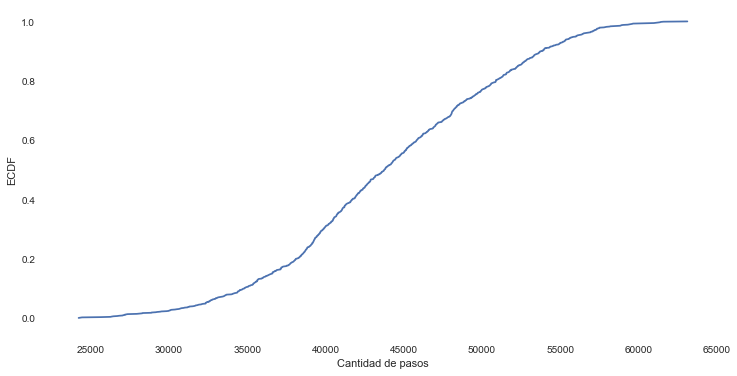

In [63]:
plt.figure(figsize = (12, 6))
cdf = ECDF(diario['cantidad_pasos'])
plt.plot(cdf.x, cdf.y, label = "statmodels")
plt.xlabel('Cantidad de pasos'); plt.ylabel('ECDF')

In [64]:
pd.DataFrame(diario.cantidad_pasos.describe())

,cantidad_pasos
count,1095.000000
mean,44065.968037
std,7282.202202
min,24220.000000
25%,39136.500000
50%,43766.000000
75%,49514.500000
max,63127.000000


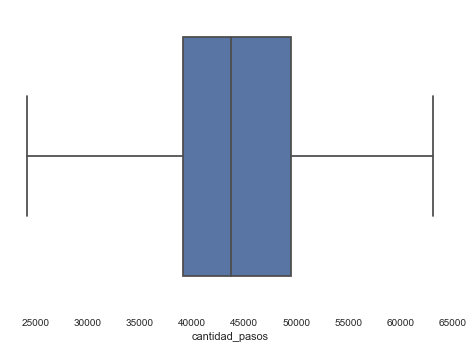

In [65]:
sns.boxplot(diario['cantidad_pasos'])

#### _De la curva ECDF y el gráfico de caja se desprenden algunas consideraciones a tener en cuenta: el 80% de los días registrados a lo largo de los tres años presenta un máximo de 50.000 cantidad de pasos (en la tabla de arriba se observa como el tercer cuartil llega hasta los 49.514), y el 20% se detecta en 37.000 (mientras que el primer cuartil en 39.136). A su vez, la mediana y la media muestran números muy similares, por lo que se puede concluir que la distribución de vehículos diaria es pareja. 1.095 registros repartidos sin valores atípicos y con una desviación estándar baja en relación con el promedio. 

## Descomposición de la serie de tiempo:

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(diario.cantidad_pasos, model='additive')

### Observamos tendencia, estacionalidad y ruido:

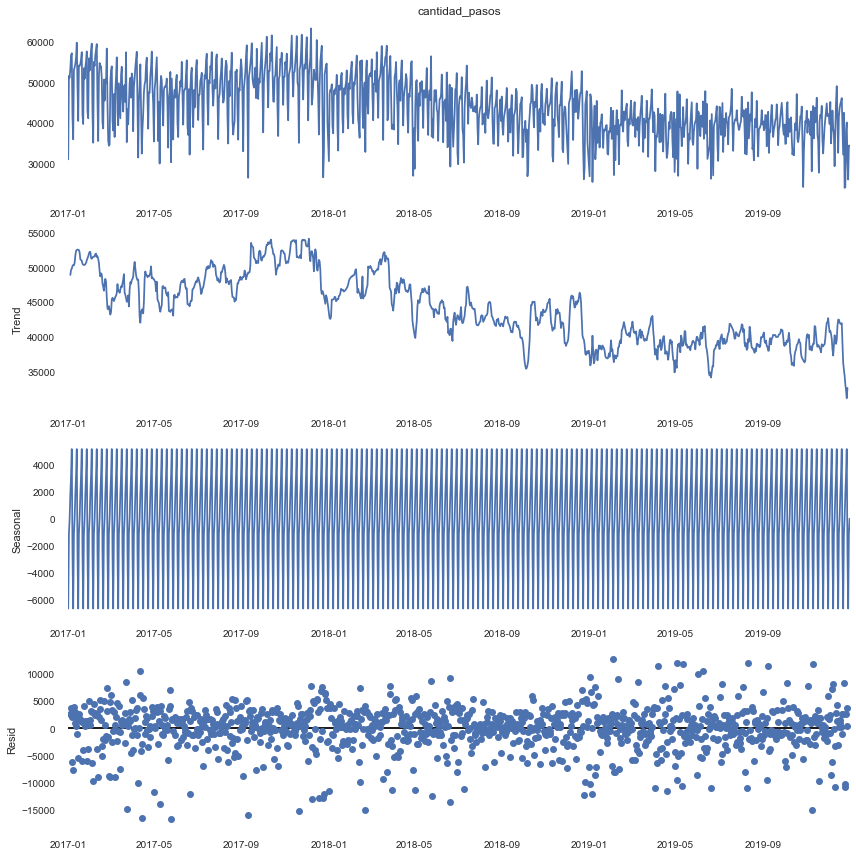

In [67]:
plt.rcParams['figure.figsize'] = [12,12]
result.plot()
plt.show()

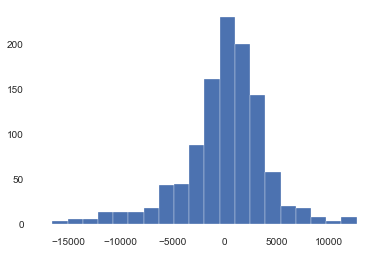

In [68]:
plt.figure(figsize = (6,4))
plt.hist(result.resid, bins = 20)
plt.show()

#### _Se observa una tendencia decreciente (2017, 2018 y 2019) en la cantidad de pasos ("y") registrados en efectivo en la autopista Illia. Además, como ya se analizó previamente, se detectan estacionalidades en frecuencia muestral diaria y por hora. Por último, cabe destacar la presencia de una distribución normal del "ruido".

In [530]:
#Autocorrelación en dataset con frecuencia muestral diaria:

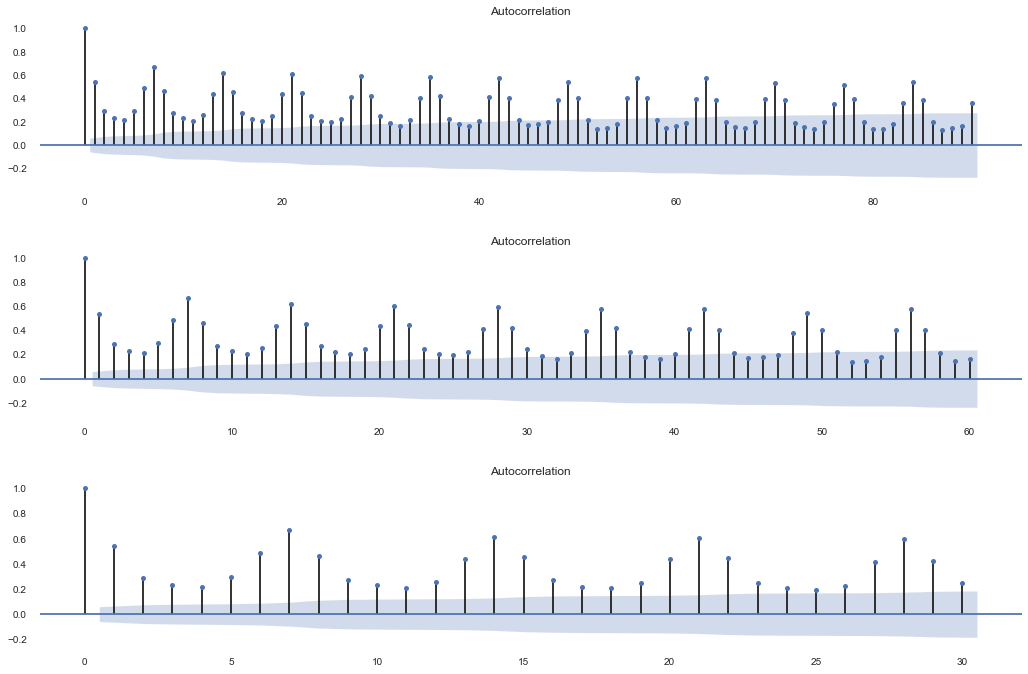

In [694]:
plt.figure(figsize=(15,10))
plt.subplot(311)
plot_acf(diario.cantidad_pasos, lags=90, ax=plt.gca())
plt.subplot(312)
plot_acf(diario.cantidad_pasos, lags=60, ax=plt.gca())
plt.subplot(313)
plot_acf(diario.cantidad_pasos, lags=30, ax=plt.gca())
plt.tight_layout(pad=3.0)
plt.show()

# Parte B - Modelo de Machine Learning

# PREDICCIONES ÚLTIMO TRIMESTRE DE 2019

#### _Tras evaluar la función de autocorrelación de la serie de tiempo con una frecuencia muestral diaria, se optó por la elección de un "look back" de seis días, ya que, además de evidenciar un considerable grado de significancia estadística en cada uno de sus lags, se percibe un mismo comportamiento cada 6 días en cada uno de los gráficos presentados.

## ONE-STEP PREDICTION:

In [653]:
one_step = diario.cantidad_pasos
one_step.head()

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [673]:
look_back = 6

In [674]:
N = one_step.shape[0]
X = np.zeros((N - look_back - 1, look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1088, 6) (1088,)


In [675]:
for i in range(X.shape[0]):
    X[i,:] = one_step.iloc[i:i+look_back]
    y[i] = one_step.iloc[i+look_back]

In [676]:
N_train = 365 + 365 + 364 - 92 - look_back
N_test = 92
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(996, 6) (996,)
(92, 6) (92,)


#### _Implementaré algoritmos de ensamble de bagging (Random Forest) y boosting (XGBoosting). Las métricas a utilizar para medir la eficiencia de los modelos serán: Raíz del error cuadrático medio (RMSE) y Error absoluto medio (MAE), ya que sendas medidas ofrecen resultados comparables con el valor real de la variable "y".

In [658]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [677]:
rf = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=4).fit(X_train,y_train)

In [678]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

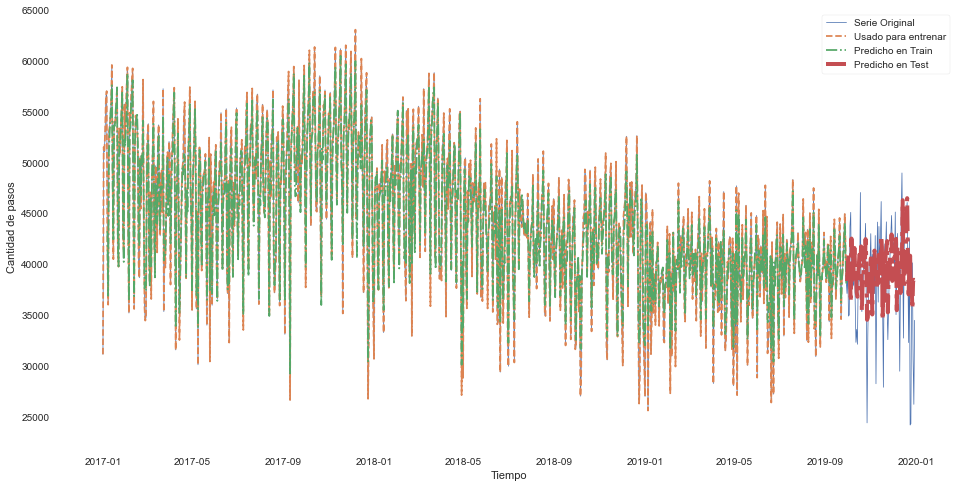

In [679]:
plt.figure(figsize=(16,8))
plt.plot(one_step.index[:length_total], one_step[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(one_step.index[:N_train + look_back], one_step[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(one_step.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(one_step.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

In [680]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

MAE = mean_absolute_error(y_train, y_train_pred)
print('MAE en Train:',MAE)
MAE = mean_absolute_error(y_test, y_test_pred)
print('MAE en Test:',MAE)

RMSE en Train: 1847.6367662780697
RMSE en Test: 4894.690393613294
MAE en Train: 1357.4416817269077
MAE en Test: 3671.488786231885


In [681]:
rf.oob_score_

0.5262720554856799

### Optimización de hiperparámetros con validación cruzada con búsqueda aleatoria y manual:

In [682]:
print('Los parámetros que utilicé en el Random Forest con valores por defecto:\n')
print(rf.get_params())

Los parámetros que utilicé en el Random Forest con valores por defecto:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 4, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [683]:
from sklearn.model_selection import RandomizedSearchCV

In [684]:
param = {'n_estimators': [75, 100, 150, 175], 'max_depth': [4, 6, 8, 10], 
         'min_samples_split': [4, 7, 10], 'max_features': ['auto', 'sqrt'],
         'bootstrap': [True, False], 'min_samples_leaf':[1, 2, 4]}

In [685]:
rf_2 = RandomForestRegressor()

In [686]:
CV_rfr = RandomizedSearchCV(estimator=rf_2, param_distributions=param, n_iter=50, 
                            cv=3, verbose=2, random_state=42, n_jobs=-1)

In [687]:
CV_rfr.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   15.9s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [4, 7, 10],
                                        'n_estimators': [75, 100, 150, 175]},
                   random_state=42, verbose=2)

In [688]:
CV_rfr.best_params_

{'n_estimators': 175,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 8,
 'bootstrap': True}

In [689]:
random_forest_optimizado = RandomForestRegressor(n_estimators=175, min_samples_split=10,min_samples_leaf=2,
                                                 max_features='auto', max_depth=8, bootstrap=True, 
                                                 random_state=42, n_jobs=-1)

In [690]:
random_forest_optimizado.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=175, n_jobs=-1)

In [691]:
y_train_pred = random_forest_optimizado.predict(X_train)
y_test_pred = random_forest_optimizado.predict(X_test)

In [692]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

MAE = mean_absolute_error(y_train, y_train_pred)
print('MAE en Train:',MAE)
MAE = mean_absolute_error(y_test, y_test_pred)
print('MAE en Test:',MAE)

RMSE en Train: 3472.160063280581
RMSE en Test: 4957.706040518094
MAE en Train: 2584.891425716661
MAE en Test: 3671.199572648462


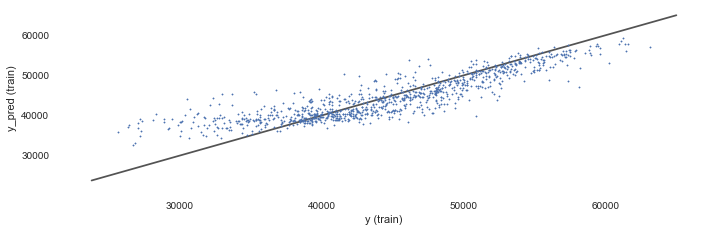

In [695]:
plt.figure(figsize = (10,6))

ax= plt.subplot(2,1,1)
ax.scatter(y_train,y_train_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  
np.max([ax.get_xlim(), ax.get_ylim()]),
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (train)')
plt.ylabel('y_pred (train)')
    
plt.tight_layout()
plt.show()

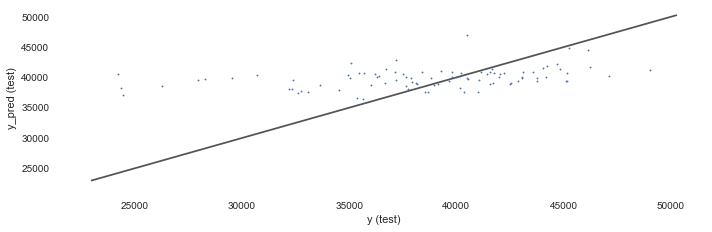

In [696]:
plt.figure(figsize = (10,6))

ax= plt.subplot(2,1,1)
ax.scatter(y_test,y_test_pred, s =2)
    
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),  
np.max([ax.get_xlim(), ax.get_ylim()]),
]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
    
plt.tight_layout()
plt.show()

#### _El modelo de Random Forest optimizado presenta valores similares al primer modelo entrenado y evaluado.

In [387]:
import xgboost as xgb

In [697]:
boosting = xgb.XGBRegressor(objective='reg:squarederror').fit(X_train, y_train)

In [698]:
y_train_pred = boosting.predict(X_train)
y_test_pred = boosting.predict(X_test)

In [699]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

MAE = mean_absolute_error(y_train, y_train_pred)
print('MAE en Train:',MAE)
MAE = mean_absolute_error(y_test, y_test_pred)
print('MAE en Test:',MAE)

RMSE en Train: 526.2588769868667
RMSE en Test: 4948.217627635447
MAE en Train: 368.4427906940261
MAE en Test: 3916.2330799932065


### Optimización de hiperparámetros con validación cruzada con búsqueda aleatoria y manual:

In [700]:
param_2 = {'n_estimators': [100, 125, 150, 175],
           'max_depth': [1, 2, 3, 4],
           'gamma': [0, 0.01, 0.03, 0.05],
           'min_child_weight': [5, 6, 7, 8]}

In [701]:
CV_boosting = RandomizedSearchCV(estimator=boosting, param_distributions=param_2, n_iter=50, 
                                 cv=3, verbose=2, random_state=42, n_jobs=-1)

In [702]:
CV_boosting.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   24.2s finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_parallel_tree=1, random_state=0,
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_

In [703]:
CV_boosting.best_params_

{'n_estimators': 100, 'min_child_weight': 6, 'max_depth': 1, 'gamma': 0.01}

In [704]:
boosting_optimizado = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
                                       max_depth=1, min_child_weight=6, gamma=0.01)

In [705]:
boosting_optimizado.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=1,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [706]:
y_train_pred = boosting_optimizado.predict(X_train)
y_test_pred = boosting_optimizado.predict(X_test)

In [707]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

MAE = mean_absolute_error(y_train, y_train_pred)
print('MAE en Train:',MAE)
MAE = mean_absolute_error(y_test, y_test_pred)
print('MAE en Test:',MAE)

RMSE en Train: 4904.529258470798
RMSE en Test: 5175.317185885451
MAE en Train: 3841.7473448481423
MAE en Test: 3891.569081182065


### Benchmark:

In [708]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]

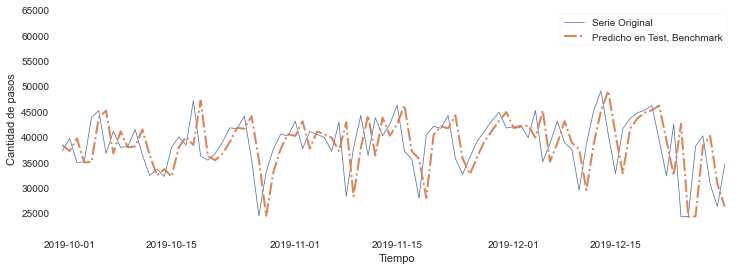

In [709]:
plt.figure(figsize=(12,4))
plt.plot(one_step.index[:length_total], one_step[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(one_step.index[N_train+look_back: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(one_step.index[N_train+look_back], one_step.index[length_total])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

In [710]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
MSE = mean_squared_error(y_test, y[-1 + N_train:N_train+N_test - 1])
MAE = mean_absolute_error(y_test, y[-1 + N_train:N_train+N_test - 1])
print('RMSE:', np.sqrt(MSE))
print('MAE:', MAE)

RMSE: 6034.584014066429
MAE: 4708.336956521739


## PROPHET:

In [117]:
from fbprophet import Prophet

In [118]:
diario.drop(columns='fecha_numeros', inplace=True)
diario.head()

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0


In [119]:
df_diario = diario.reset_index()

In [120]:
df_diario.columns = ['ds','y']

In [121]:
df_diario.head()

,ds,y
0,2017-01-01,31183.0
1,2017-01-02,51568.0
2,2017-01-03,51093.0
3,2017-01-04,53332.0
4,2017-01-05,56486.0


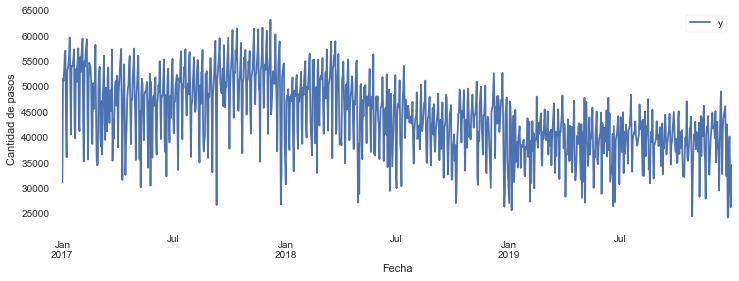

In [122]:
ax = df_diario.set_index('ds').plot(figsize = (12, 4))
ax.set_ylabel('Cantidad de pasos')
ax.set_xlabel('Fecha')
plt.show()

In [123]:
df_diario.shape

(1095, 2)

In [124]:
df_diario_prediccion = df_diario.tail(92)

In [125]:
df_diario_prediccion

,ds,y
1003,2019-10-01,39669.0
1004,2019-10-02,34943.0
1005,2019-10-03,35054.0
1006,2019-10-04,43775.0
1007,2019-10-05,45150.0
...,...,...
1090,2019-12-27,40182.0
1091,2019-12-28,30681.0
1092,2019-12-29,26259.0
1093,2019-12-30,34523.0


In [126]:
prediction_size = 92
train_df = df_diario.iloc[:-prediction_size]

In [127]:
train_df.shape

(1003, 2)

In [128]:
modelo = Prophet(daily_seasonality=True, weekly_seasonality=True)
modelo.fit(train_df)

In [129]:
future = modelo.make_future_dataframe(periods=prediction_size)

In [130]:
future

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05
...,...
1090,2019-12-27
1091,2019-12-28
1092,2019-12-29
1093,2019-12-30


In [131]:
forecast = modelo.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,34733.585275,34629.956495,45411.738469,34733.585275,34733.585275,5079.844374,5079.844374,5079.844374,14283.047286,...,-7014.491935,-7014.491935,-7014.491935,-2188.710976,-2188.710976,-2188.710976,0.0,0.0,0.0,39813.429649
1,2017-01-02,34733.192770,40125.758979,50920.708554,34733.192770,34733.192770,10980.039298,10980.039298,10980.039298,14283.047286,...,-1050.450398,-1050.450398,-1050.450398,-2252.557590,-2252.557590,-2252.557590,0.0,0.0,0.0,45713.232068
2,2017-01-03,34732.800264,41555.286030,52437.717693,34732.800264,34732.800264,12112.351534,12112.351534,12112.351534,14283.047286,...,114.344021,114.344021,114.344021,-2285.039773,-2285.039773,-2285.039773,0.0,0.0,0.0,46845.151798
3,2017-01-04,34732.407759,43346.690585,54414.858448,34732.407759,34732.407759,13963.837325,13963.837325,13963.837325,14283.047286,...,1968.069488,1968.069488,1968.069488,-2287.279449,-2287.279449,-2287.279449,0.0,0.0,0.0,48696.245083
4,2017-01-05,34732.015253,44563.461112,55669.624108,34732.015253,34732.015253,15329.773071,15329.773071,15329.773071,14283.047286,...,3307.575614,3307.575614,3307.575614,-2260.849829,-2260.849829,-2260.849829,0.0,0.0,0.0,50061.788324


In [132]:
último_trimestre_2019 = forecast.tail(92)

In [133]:
último_trimestre_2019

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1003,2019-10-01,25515.361315,35066.529833,46263.921323,25515.361315,25515.361315,15001.408784,15001.408784,15001.408784,14283.047286,...,114.344021,114.344021,114.344021,604.017477,604.017477,604.017477,0.0,0.0,0.0,40516.770099
1004,2019-10-02,25515.124914,36289.681151,48091.136863,25515.124914,25515.124914,16833.569411,16833.569411,16833.569411,14283.047286,...,1968.069488,1968.069488,1968.069488,582.452637,582.452637,582.452637,0.0,0.0,0.0,42348.694325
1005,2019-10-03,25514.888513,37638.630080,49221.711011,25514.888513,25514.888513,18157.808010,18157.808010,18157.808010,14283.047286,...,3307.575614,3307.575614,3307.575614,567.185110,567.185110,567.185110,0.0,0.0,0.0,43672.696523
1006,2019-10-04,25514.652112,40091.862525,51326.057860,25514.652112,25514.652112,20145.268815,20145.268815,20145.268815,14283.047286,...,5302.009457,5302.009457,5302.009457,560.212073,560.212073,560.212073,0.0,0.0,0.0,45659.920927
1007,2019-10-05,25514.415710,31822.988550,43346.318288,25514.415710,25514.415710,12219.376630,12219.376630,12219.376630,14283.047286,...,-2627.056247,-2627.056247,-2627.056247,563.385591,563.385591,563.385591,0.0,0.0,0.0,37733.792341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2019-12-27,25494.794400,38496.522562,49141.444428,25228.549689,25761.046362,18372.180356,18372.180356,18372.180356,14283.047286,...,5302.009457,5302.009457,5302.009457,-1212.876386,-1212.876386,-1212.876386,0.0,0.0,0.0,43866.974757
1091,2019-12-28,25494.557999,29472.110033,41183.507941,25224.123464,25765.427545,10203.037892,10203.037892,10203.037892,14283.047286,...,-2627.056247,-2627.056247,-2627.056247,-1452.953147,-1452.953147,-1452.953147,0.0,0.0,0.0,35697.595891
1092,2019-12-29,25494.321598,25071.085902,36744.095960,25218.029197,25768.302614,5603.212669,5603.212669,5603.212669,14283.047286,...,-7014.491935,-7014.491935,-7014.491935,-1665.342682,-1665.342682,-1665.342682,0.0,0.0,0.0,31097.534266
1093,2019-12-30,25494.085196,31109.345488,42639.069342,25210.017489,25771.651604,11384.475667,11384.475667,11384.475667,14283.047286,...,-1050.450398,-1050.450398,-1050.450398,-1848.121220,-1848.121220,-1848.121220,0.0,0.0,0.0,36878.560864


In [134]:
último_trimestre_2019[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1088,2019-12-25,41086.496125,35156.397384,46521.495736
1089,2019-12-26,42138.104269,36223.192405,47880.619716
1090,2019-12-27,43866.974757,38496.522562,49141.444428
1091,2019-12-28,35697.595891,29472.110033,41183.507941
1092,2019-12-29,31097.534266,25071.085902,36744.095960
1093,2019-12-30,36878.560864,31109.345488,42639.069342
1094,2019-12-31,37891.338678,31932.998705,43712.105634


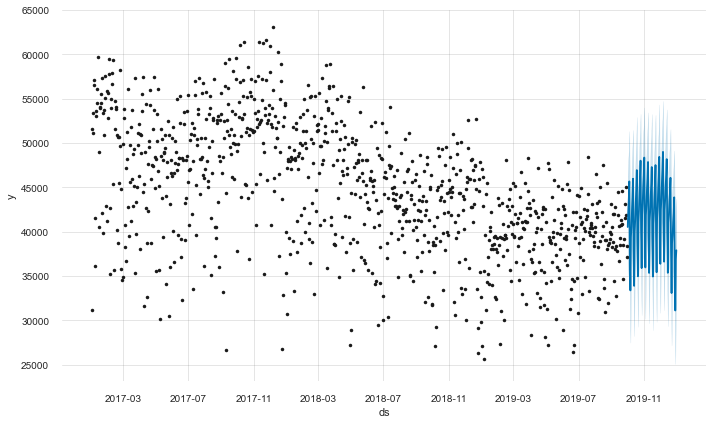

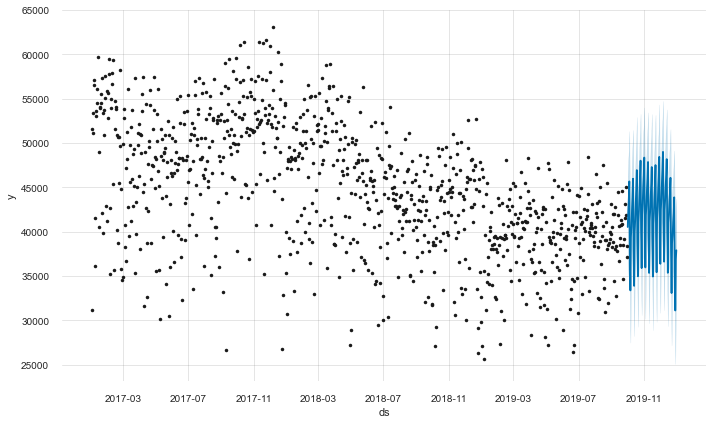

In [135]:
modelo.plot(último_trimestre_2019)

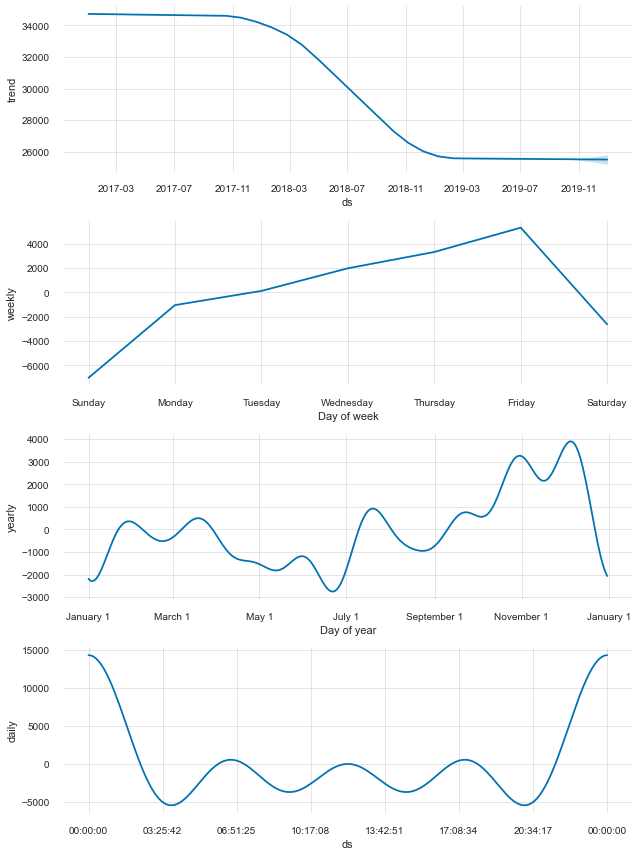

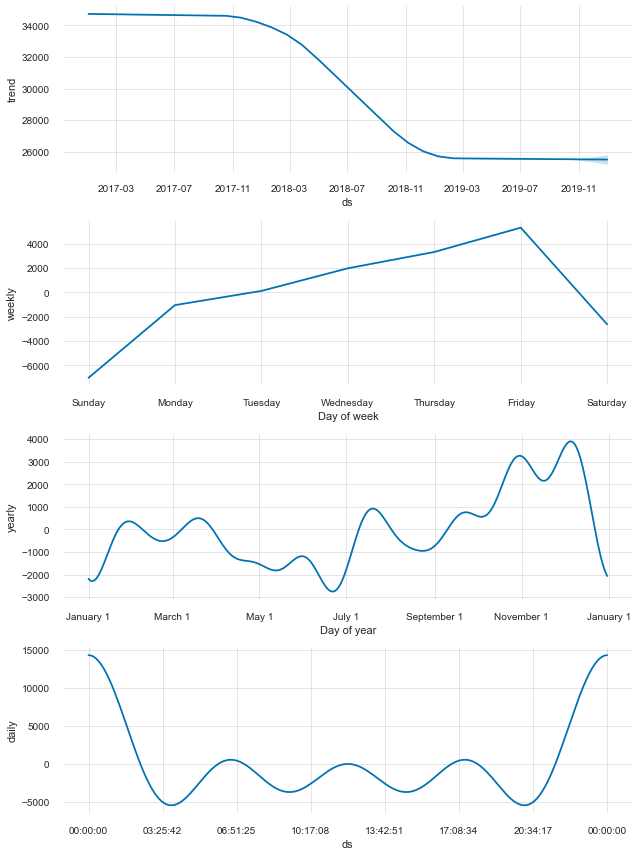

In [136]:
modelo.plot_components(forecast)

In [137]:
def dataframe_evaluación(df_diario_prediccion, último_trimestre_2019):
    return último_trimestre_2019.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_diario_prediccion.set_index('ds'))

In [138]:
df_comparación = dataframe_evaluación(df_diario_prediccion, último_trimestre_2019)

df_comparación

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2019-10-01,40516.770099,35066.529833,46263.921323,39669.0
2019-10-02,42348.694325,36289.681151,48091.136863,34943.0
2019-10-03,43672.696523,37638.630080,49221.711011,35054.0
2019-10-04,45659.920927,40091.862525,51326.057860,43775.0
2019-10-05,37733.792341,31822.988550,43346.318288,45150.0
...,...,...,...,...
2019-12-27,43866.974757,38496.522562,49141.444428,40182.0
2019-12-28,35697.595891,29472.110033,41183.507941,30681.0
2019-12-29,31097.534266,25071.085902,36744.095960,26259.0


In [139]:
def forecast_errors(df_comparación):
    
    df_comparación_resultados = df_comparación
    
    df_comparación_resultados['error'] = df_comparación_resultados['y'] - df_comparación_resultados['yhat']
    
    df_comparación_resultados['porcentaje_error'] = 100 * df_comparación_resultados['error'] / df_comparación_resultados['y']
    
    MSE = mean_squared_error(df_comparación_resultados['y'], df_comparación_resultados['yhat'])
    
    RMSE = np.sqrt(mean_squared_error(df_comparación_resultados['y'], df_comparación_resultados['yhat']))
    
    return df_comparación_resultados, MSE, RMSE

In [140]:
forecast_errors(df_comparación)

(                    yhat    yhat_lower    yhat_upper        y        error  \
 ds                                                                           
 2019-10-01  40516.770099  35066.529833  46263.921323  39669.0  -847.770099   
 2019-10-02  42348.694325  36289.681151  48091.136863  34943.0 -7405.694325   
 2019-10-03  43672.696523  37638.630080  49221.711011  35054.0 -8618.696523   
 2019-10-04  45659.920927  40091.862525  51326.057860  43775.0 -1884.920927   
 2019-10-05  37733.792341  31822.988550  43346.318288  45150.0  7416.207659   
 ...                  ...           ...           ...      ...          ...   
 2019-12-27  43866.974757  38496.522562  49141.444428  40182.0 -3684.974757   
 2019-12-28  35697.595891  29472.110033  41183.507941  30681.0 -5016.595891   
 2019-12-29  31097.534266  25071.085902  36744.095960  26259.0 -4838.534266   
 2019-12-30  36878.560864  31109.345488  42639.069342  34523.0 -2355.560864   
 2019-12-31  37891.338678  31932.998705  43712.10563

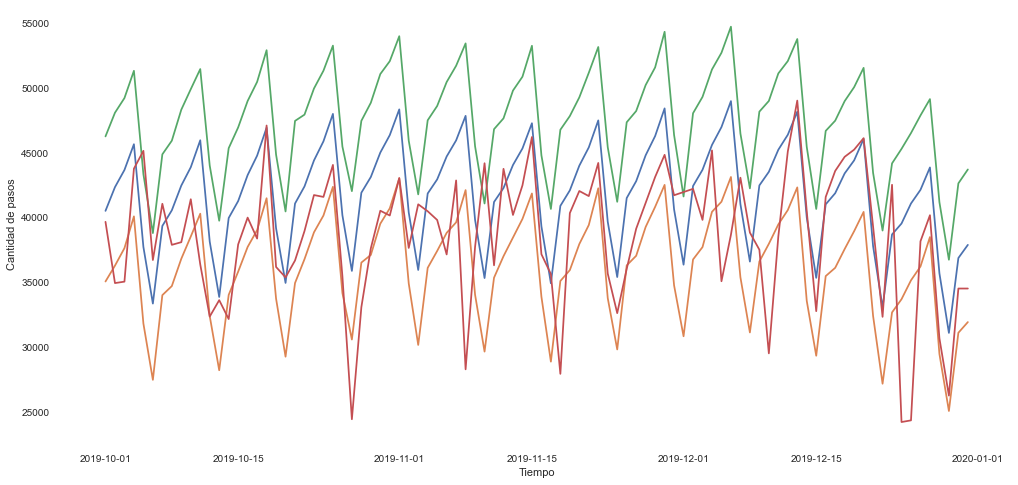

In [141]:
plt.figure(figsize=(17, 8))
plt.plot(df_comparación['yhat'])
plt.plot(df_comparación['yhat_lower'])
plt.plot(df_comparación['yhat_upper'])
plt.plot(df_comparación['y'])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.grid(False)
plt.show()

# Predicciones último trimestre 2019 resultados (RMSE):

### One-step Random Forest: train -3.472- y test -4.957- (ELEGIDO).

### One-step XGBoosting: train -4.904- y test -5.175-.

### Prophet: test -5.768-.

### Benchmark: test -6.034-.

# PREDICCIONES DE 2020

#### _Al momento de la entrega del Proyecto (octubre de 2020), el dataset de ese año puesto a disposición por el Gobierno de la Ciudad de Buenos Aires disponía de los registros hasta el 31 de agosto. Es decir, los datos de los primeros ocho meses. A continuación, se ejecutará un modelo "One-step" con el objeto de predecir el tráfico de vehículos en los primeros ocho meses del 2020. Finalmente, se optará por la librería "Prophet" ya en búsqueda de inferir la cantidad de pasos del año entero.

In [454]:
data_2020 = pd.read_csv('C:/Users/guido/Desktop/flujo-vehicular-2020.csv', sep =',')

In [438]:
print(data_2020.shape)
print(data_2020.tail())

(1628081, 13)
         periodo       fecha     mes    dia  dia_fecha  hora_inicio  hora_fin  \
1628076     2020  2020-08-31  agosto  Lunes         31           23         0   
1628077     2020  2020-08-31  agosto  Lunes         31           23         0   
1628078     2020  2020-08-31  agosto  Lunes         31           23         0   
1628079     2020  2020-08-31  agosto  Lunes         31           23         0   
1628080     2020  2020-08-31  agosto  Lunes         31           23         0   

        estacion   tipo_vehiculo forma_pago         observacion    sentido  \
1628076      PB1  Pesados 6 Ejes        Tag       Tag - PosPago  Provincia   
1628077      PB1  Pesados 6 Ejes  Violación  Violación - Normal  Provincia   
1628078      PB4  Pesados 6 Ejes        Tag       Tag - PosPago     Centro   
1628079      PB4  Pesados 6 Ejes        Tag   Tag - PosPago OCR     Centro   
1628080      PB4  Pesados 6 Ejes  Violación  Violación - Normal     Centro   

         cantidad_pasos  
1628

In [439]:
data_2020.columns

Index(['periodo', 'fecha', 'mes', 'dia', 'dia_fecha', 'hora_inicio',
       'hora_fin', 'estacion', 'tipo_vehiculo', 'forma_pago', 'observacion',
       'sentido', 'cantidad_pasos'],
      dtype='object')

In [455]:
data_2020.forma_pago.unique()

array(['Efectivo', 'Rec.Deuda', 'Tarjeta Magnética', 'Tag', 'Exento',
       'Violación', 'CPP'], dtype=object)

In [456]:
data_2020.estacion.unique()

array(['ALBERDI', 'AVELLANEDA', 'DELLEPIANE LINIERSLEPIANE CENTRO',
       'DELLEPIANE LINIERS', 'ILLIA', 'ILP', 'PB1', 'PB3', 'PB4',
       'RETIRO', 'SALGUERO', 'SARMIENTO', 'PB2'], dtype=object)

In [457]:
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask]

In [458]:
data_2020.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion', 'sentido', 
                          'mes', 'dia_fecha', 'observacion'], inplace = True)

In [459]:
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

In [460]:
data_2020.head()

,fecha,dia,hora_fin,tipo_vehiculo,cantidad_pasos,fecha2
52,2020-01-01 00:00:00,Miércoles,1,Auto,326,2020-01-01 01:00:00
53,2020-01-01 00:00:00,Miércoles,1,Auto,319,2020-01-01 01:00:00
134,2020-01-01 00:00:00,Miércoles,2,Auto,199,2020-01-01 02:00:00
135,2020-01-01 00:00:00,Miércoles,2,Auto,180,2020-01-01 02:00:00
202,2020-01-01 00:00:00,Miércoles,3,Auto,114,2020-01-01 03:00:00


In [461]:
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 

data_2020.sort_values('fecha', inplace = True)

data_2020.reset_index(drop=True, inplace = True)

In [462]:
diario_2020 = data_2020.resample('D', on = 'fecha').sum()
diario_2020.head()

,cantidad_pasos
fecha,
2020-01-01,21395
2020-01-02,33722
2020-01-03,37067
2020-01-04,30627
2020-01-05,27812


In [555]:
diario_2020.shape

(244, 1)

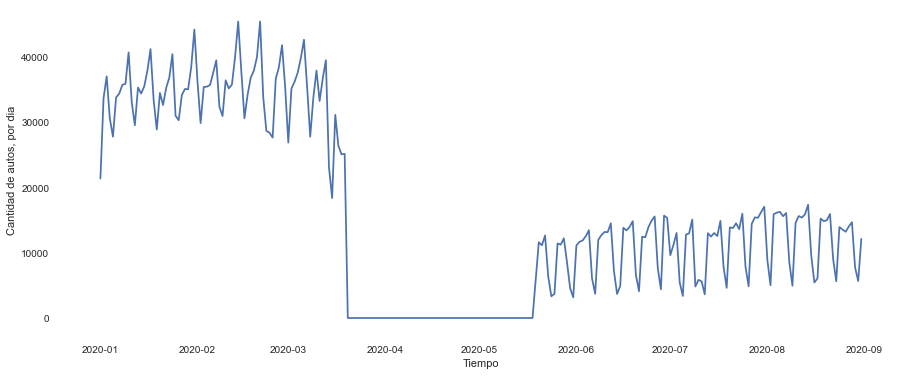

In [556]:
plt.figure(figsize = (15,6))
plt.plot(diario_2020.index, diario_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [561]:
cuarentena = diario_2020[(diario_2020.cantidad_pasos == 0)]

In [562]:
cuarentena

,cantidad_pasos
fecha,
2020-03-20,0
2020-03-21,0
2020-03-22,0
2020-03-23,0
2020-03-24,0
2020-03-25,0
2020-03-26,0
2020-03-27,0
2020-03-28,0


In [567]:
pre_cuarentena = diario_2020[(diario_2020.cantidad_pasos > 18000)]

In [574]:
print(pre_cuarentena.cantidad_pasos.mean())
pre_cuarentena

34456.59493670886


,cantidad_pasos
fecha,
2020-01-01,21395
2020-01-02,33722
2020-01-03,37067
2020-01-04,30627
2020-01-05,27812
...,...
2020-03-15,18390
2020-03-16,31168
2020-03-17,26407


In [571]:
post_cuarentena = diario_2020[(diario_2020.cantidad_pasos < 18000) & (diario_2020.cantidad_pasos != 0)]

In [573]:
print(post_cuarentena.cantidad_pasos.mean())
post_cuarentena

10943.405660377359


,cantidad_pasos
fecha,
2020-05-11,1
2020-05-19,5724
2020-05-20,11616
2020-05-21,11149
2020-05-22,12653
...,...
2020-08-27,14034
2020-08-28,14696
2020-08-29,7767


In [644]:
diario_con_2020 = pd.concat([diario, diario_2020])

In [645]:
diario_con_2020.shape

(1339, 1)

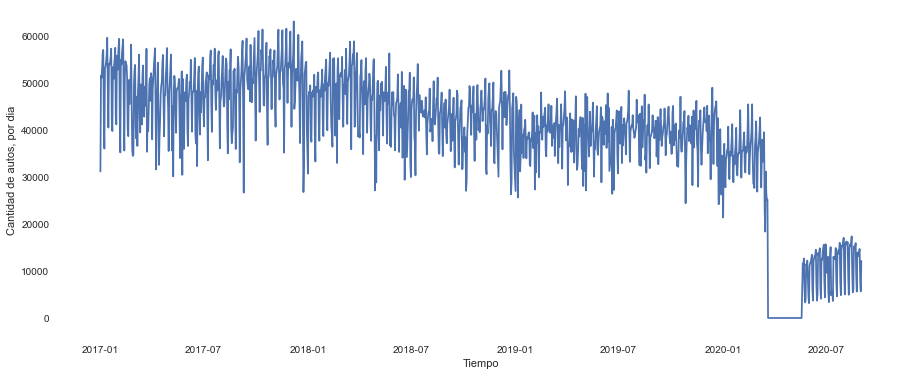

In [640]:
plt.figure(figsize = (15,6))
plt.plot(diario_con_2020.index, diario_con_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [477]:
diario_2020.cantidad_pasos.quantile(q=0.99)

43576.90999999999

In [478]:
diario.cantidad_pasos.quantile(q=0.50)

43766.0

#### _Como muestran los números, el 99% de los días del 2020 (hasta el 31/8) presentan una cantidad de pasos inferior a 43.576, mientras que el 50% -la mediana- de los días entre 2017 y 2019 ya supera esa cifra con 43.766. Esto se debe al quiebre en la serie de tiempo provocada por el anuncio del Aislamiento Social Preventivo y Obligatorio (ASPO) -a partir del 20/3- a causa de la pandemia del Covid-19. En el período que va entre la fecha mencionada y el 19/5 -día en el cual el peaje Illia retornó a su habitual funcionamiento, se detectaron 0 (cero) cantidad de pasos. Por lo tanto, se prevé un incorrecto desarrollo del modelo Random Forest para predecir el 2020. No obstante, y más allá de las constantes prórrogas de cuarentenas decretadas en el área que afecta al peaje en estudio, se observa como se mantiene la tendencia decreciente con relación a los años anteriores. Los niveles de tráfico precuarentena tenían una media de casi 35.000, mientras que los registros tomados tras la vuelta al cobro arrojan una media poco inferior a 11.000. Los valores atípicos registrados a partir de la cuarentena se extienden hasta el final del dataset (31/8/2020) ya que, más allá de que la caja del peaje haya retomado sus actividades con normalidad, desde el Estado nacional ya se había anunciado que desde el 28 de septiembre de 2020 entraría en vigencia una nueva regulación que sólo permitiría el pago con Telepase, por lo que los datos volvieron con registros considerablemente bajos con respecto a los que se venían mostrando desde 2017. Como conclusión, las instancias incluidas con posterioridad al 20/3/2020 -fecha de comienzo del ASPO- carecen de rigurosidad estadística debido a dos factores externos que el modelo jamás pordría prever en sus proyecciones: cuarentena y prohibición del pago en efectivo. 

In [646]:
primer_cuartil = np.quantile(diario_con_2020['cantidad_pasos'], 0.25)
tercer_cuartil = np.quantile(diario_con_2020['cantidad_pasos'], 0.75)
rango_intercuartílico = tercer_cuartil - primer_cuartil
mínimo_permitido = primer_cuartil - (1.5*rango_intercuartílico)
máximo_permitido = tercer_cuartil + (1.5*rango_intercuartílico)
outliers = diario_con_2020[(diario_con_2020.cantidad_pasos < mínimo_permitido) | (diario_con_2020.cantidad_pasos > máximo_permitido)]

In [647]:
outliers

,cantidad_pasos
fecha,
2020-03-20,0.0
2020-03-21,0.0
2020-03-22,0.0
2020-03-23,0.0
2020-03-24,0.0
...,...
2020-08-27,14034.0
2020-08-28,14696.0
2020-08-29,7767.0


In [648]:
diario_con_2020.cantidad_pasos[diario_con_2020.cantidad_pasos > máximo_permitido] = np.nan
diario_con_2020.cantidad_pasos[diario_con_2020.cantidad_pasos < mínimo_permitido] = np.nan

In [649]:
diario_con_2020.isna().sum()

cantidad_pasos    163
dtype: int64

In [650]:
diario_con_2020 = diario_con_2020.interpolate(method='time')
print(diario_con_2020.isna().sum())

cantidad_pasos    0
dtype: int64


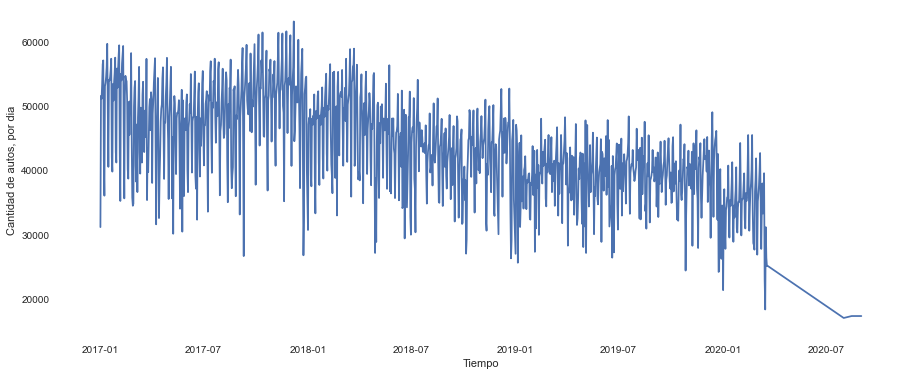

In [651]:
plt.figure(figsize = (15,6))
plt.plot(diario_con_2020.index, diario_con_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

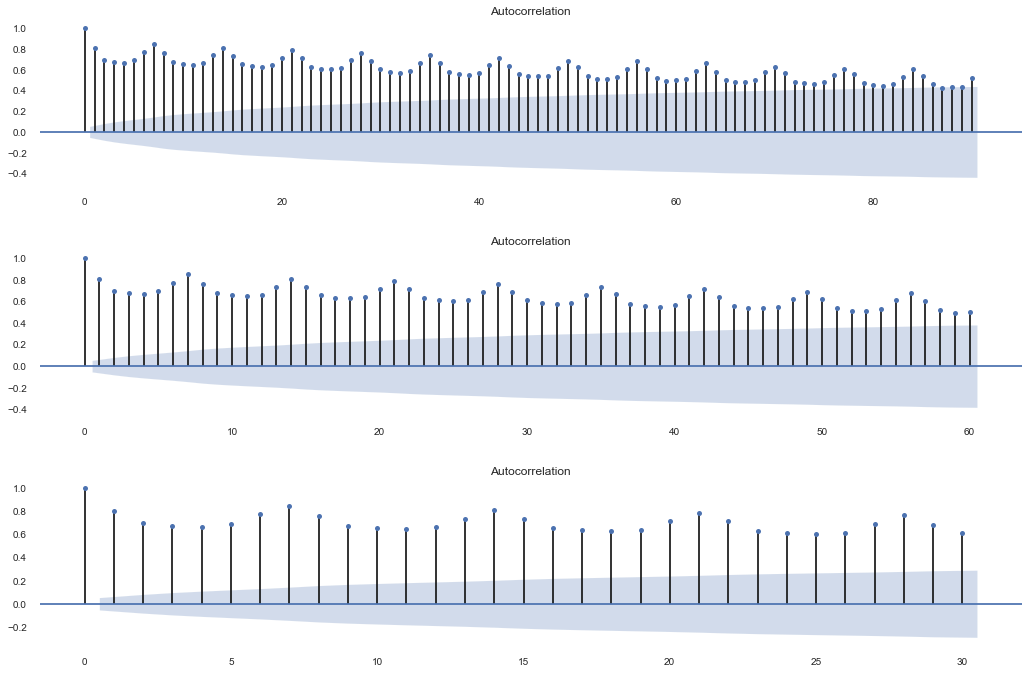

In [652]:
plt.figure(figsize=(15,10))
plt.subplot(311)
plot_acf(diario_con_2020.cantidad_pasos, lags=90, ax=plt.gca())
plt.subplot(312)
plot_acf(diario_con_2020.cantidad_pasos, lags=60, ax=plt.gca())
plt.subplot(313)
plot_acf(diario_con_2020.cantidad_pasos, lags=30, ax=plt.gca())
plt.tight_layout(pad=3.0)
plt.show()

## ONE-STEP PREDICTION:

In [546]:
one_step = diario_con_2020.cantidad_pasos
one_step.head()

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [547]:
look_back = 30

In [548]:
N = one_step.shape[0]
X = np.zeros((N - look_back - 1, look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1308, 30) (1308,)


In [549]:
for i in range(X.shape[0]):
    X[i,:] = one_step.iloc[i:i+look_back]
    y[i] = one_step.iloc[i+look_back]

In [550]:
N_train = 1338 - 244 - look_back
N_test = 244
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(1064, 30) (1064,)
(244, 30) (244,)


In [551]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1).fit(X_train,y_train)

In [552]:
y_pred = rf.predict(X)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

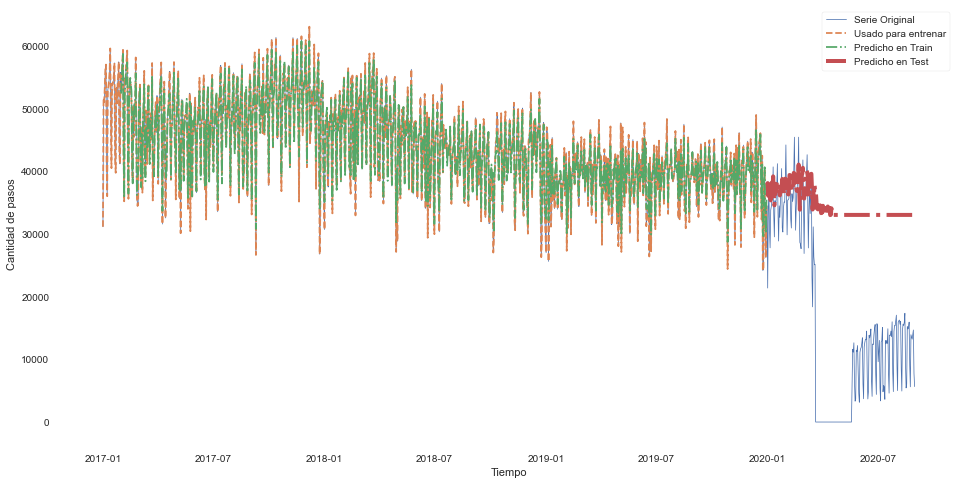

In [553]:
plt.figure(figsize=(16,8))
plt.plot(one_step.index[:length_total], one_step[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(one_step.index[:N_train + look_back], one_step[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(one_step.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(one_step.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()

In [554]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))
MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

MAE = mean_absolute_error(y_train, y_train_pred)
print('MAE en Train:',MAE)
MAE = mean_absolute_error(y_test, y_test_pred)
print('MAE en Test:',MAE)

RMSE en Train: 1713.4885651678462
RMSE en Test: 22387.630226012083
MAE en Train: 1236.883831453634
MAE en Test: 18943.567243852463


# Parte C - Investigación

## PROPHET:

In [425]:
future_2 = modelo.make_future_dataframe(periods=prediction_size+366)

In [426]:
future_2.tail(10)

,ds
1451,2020-12-22
1452,2020-12-23
1453,2020-12-24
1454,2020-12-25
1455,2020-12-26
1456,2020-12-27
1457,2020-12-28
1458,2020-12-29
1459,2020-12-30
1460,2020-12-31


In [427]:
forecast = modelo.predict(future_2)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,34733.585275,34260.015562,45368.528319,34733.585275,34733.585275,5079.844374,5079.844374,5079.844374,14283.047286,...,-7014.491935,-7014.491935,-7014.491935,-2188.710976,-2188.710976,-2188.710976,0.0,0.0,0.0,39813.429649
1,2017-01-02,34733.192770,40374.029404,51448.039209,34733.192770,34733.192770,10980.039298,10980.039298,10980.039298,14283.047286,...,-1050.450398,-1050.450398,-1050.450398,-2252.557590,-2252.557590,-2252.557590,0.0,0.0,0.0,45713.232068
2,2017-01-03,34732.800264,41463.376397,52673.678318,34732.800264,34732.800264,12112.351534,12112.351534,12112.351534,14283.047286,...,114.344021,114.344021,114.344021,-2285.039773,-2285.039773,-2285.039773,0.0,0.0,0.0,46845.151798
3,2017-01-04,34732.407759,43047.153763,53933.283765,34732.407759,34732.407759,13963.837325,13963.837325,13963.837325,14283.047286,...,1968.069488,1968.069488,1968.069488,-2287.279449,-2287.279449,-2287.279449,0.0,0.0,0.0,48696.245083
4,2017-01-05,34732.015253,44484.829474,56154.851672,34732.015253,34732.015253,15329.773071,15329.773071,15329.773071,14283.047286,...,3307.575614,3307.575614,3307.575614,-2260.849829,-2260.849829,-2260.849829,0.0,0.0,0.0,50061.788324


In [430]:
año_2020 = forecast.tail(366)

In [431]:
año_2020

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1095,2020-01-01,25493.612394,34016.086374,45289.811789,25211.393166,25801.884410,14131.272997,14131.272997,14131.272997,14283.047286,...,1968.069488,1968.069488,1968.069488,-2119.843777,-2119.843777,-2119.843777,0.0,0.0,0.0,39624.885391
1096,2020-01-02,25493.375993,35121.495025,46575.741267,25207.339246,25810.819964,15382.966616,15382.966616,15382.966616,14283.047286,...,3307.575614,3307.575614,3307.575614,-2207.656283,-2207.656283,-2207.656283,0.0,0.0,0.0,40876.342609
1097,2020-01-03,25493.139591,36924.273649,48253.668085,25201.360180,25816.951928,17321.473908,17321.473908,17321.473908,14283.047286,...,5302.009457,5302.009457,5302.009457,-2263.582835,-2263.582835,-2263.582835,0.0,0.0,0.0,42814.613499
1098,2020-01-04,25492.903190,29171.702218,40594.049332,25195.156263,25822.968387,9367.610187,9367.610187,9367.610187,14283.047286,...,-2627.056247,-2627.056247,-2627.056247,-2288.380852,-2288.380852,-2288.380852,0.0,0.0,0.0,34860.513377
1099,2020-01-05,25492.666789,25114.420708,36448.363105,25189.695553,25827.312034,4985.266290,4985.266290,4985.266290,14283.047286,...,-7014.491935,-7014.491935,-7014.491935,-2283.289060,-2283.289060,-2283.289060,0.0,0.0,0.0,30477.933079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,25408.271517,25058.120949,38182.874160,22148.688915,29081.940070,5873.112367,5873.112367,5873.112367,14283.047286,...,-7014.491935,-7014.491935,-7014.491935,-1395.442983,-1395.442983,-1395.442983,0.0,0.0,0.0,31281.383884
1457,2020-12-28,25408.035115,30625.528036,43970.906759,22134.772620,29089.369007,11617.641675,11617.641675,11617.641675,14283.047286,...,-1050.450398,-1050.450398,-1050.450398,-1614.955212,-1614.955212,-1614.955212,0.0,0.0,0.0,37025.676790
1458,2020-12-29,25407.798714,31056.600836,44410.460277,22133.022896,29097.572798,12592.103504,12592.103504,12592.103504,14283.047286,...,114.344021,114.344021,114.344021,-1805.287803,-1805.287803,-1805.287803,0.0,0.0,0.0,37999.902218
1459,2020-12-30,25407.562313,33285.164002,46575.400092,22125.916555,29105.586295,14286.198995,14286.198995,14286.198995,14283.047286,...,1968.069488,1968.069488,1968.069488,-1964.917778,-1964.917778,-1964.917778,0.0,0.0,0.0,39693.761308


In [432]:
año_2020[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1454,2020-12-25,44116.196948,37044.392437,49617.764860
1455,2020-12-26,35915.693129,29632.142299,42670.869961
1456,2020-12-27,31281.383884,25058.120949,38182.874160
1457,2020-12-28,37025.676790,30625.528036,43970.906759
1458,2020-12-29,37999.902218,31056.600836,44410.460277
1459,2020-12-30,39693.761308,33285.164002,46575.400092
1460,2020-12-31,40905.080568,34632.101372,47692.669277


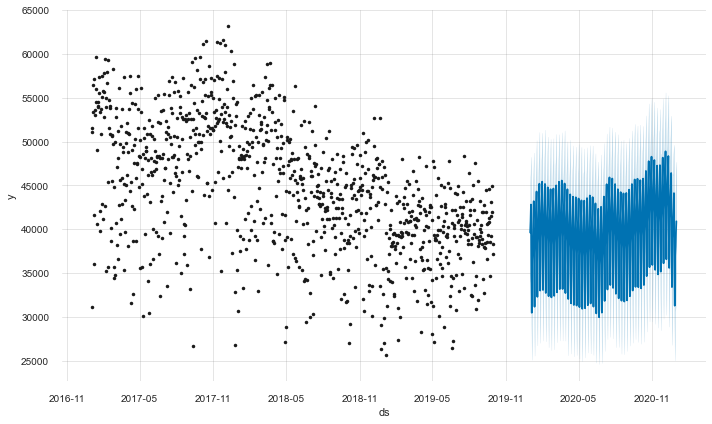

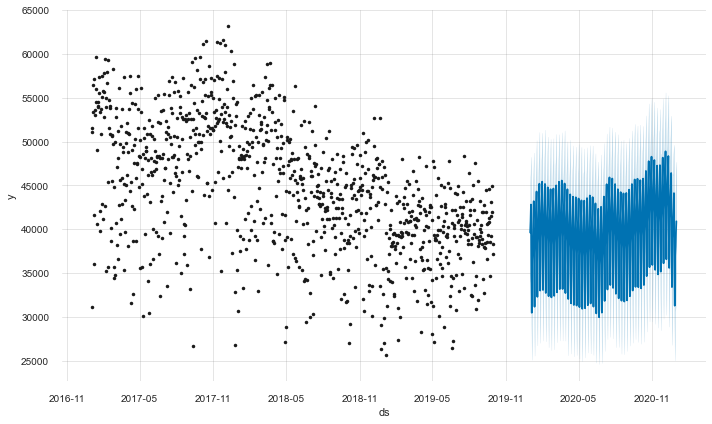

In [433]:
modelo.plot(año_2020)

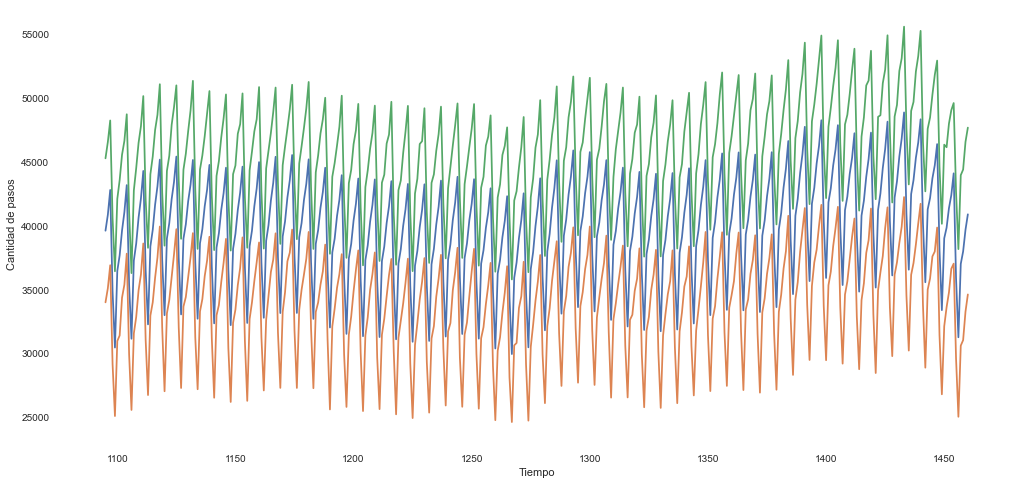

In [436]:
plt.figure(figsize=(17, 8))
plt.plot(año_2020['yhat'])
plt.plot(año_2020['yhat_lower'])
plt.plot(año_2020['yhat_upper'])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.grid(False)
plt.show()

### _El modelo de "Prophet" que había sido utilizado para predecir el último trimestre de 2019 -octubre, noviembre y diciembre- aparenta ofrecer una correcta predicción para el 2020 (si no se tomara en consideración el abrupto descenso experimentado en el período ya analizado del último año a raíz de la cuarentena obligatoria decretada en el Área Metropolitana de Buenos Aires con motivo del Covid-19 y la política pública de prohibición de forma de pago en efectivo.

### _A modo de conclusión, creo que resultaría vital agregar los datasets de 2014, 2015 y 2016, con el fin de duplicar el tamaño de la muestra con la que alimentaremos al algoritmo correspondiente, y tomar el total de las filas del peaje "Illia", añadiendo otras variables categóricas, como forma de pago, sentido o tipo de vehículo, mediante un procedimiento de codificación de las mismas. Además, incluir en un mismo filtro por método de pago a las opciones de efectivo y telepase con el fin de analizar la existencia de una tendencia en el largo plazo. 

In [715]:
# AQUÍ SE ENCUENTRA SUBIDO EL PROYECTO ENTREGADO: https://github.com/guidogambini/Proyecto-DataScience---Ac-mica  